# Thermostat

In this example we have a look at a thermostat, which is a kind off discrete regulator. It switches a heating element on or of depending on defined upper and lower thresholds.

You can also find this example as a single file in the [GitHub repository](https://github.com/milanofthe/pathsim/blob/master/examples/examples_event/example_thermostat.py).

The continuous dynamics part of the system has the following two ODEs for the two heater states:

$$\begin{cases} 
\dot{T} = - a ( T - T_a ) + H & \text{heater on} \\
\dot{T} = - a ( T - T_a )     &  \text{heater off}
\end{cases}$$

With some algebraic manipulations we can translate the system equation into a block diagram that can be implemented in PathSim. Note the event manager, that watches the state of the integrator and controls the heater.

In [1]:
import matplotlib.pyplot as plt

# Apply PathSim docs matplotlib style for consistent, theme-friendly figures
plt.style.use('../pathsim_docs.mplstyle')

from pathsim import Simulation, Connection
from pathsim.blocks import Integrator, Constant, Scope, Amplifier, Adder

# Event managers
from pathsim.events import ZeroCrossingUp, ZeroCrossingDown

Then lets define the system parameters.

In [2]:
a = 0.3  # thermal capacity of room
Ta = 10  # ambient temperature
H = 5    # heater power
Kp = 25  # upper temperature threshold 
Km = 23  # lower temperature threshold

Now we can construct the continuous dynamic part of the system (its just a linear feedback system) by instantiating the blocks we need with their corresponding prameters and collect them together in a list:

In [3]:
# Blocks that define the system
sco = Scope(labels=["temperature", "heater"])
integ = Integrator(Ta)
feedback = Amplifier(-a)
heater = Constant(H)
ambient = Constant(a*Ta)
add = Adder()

# Blocks of the main system
blocks = [sco, integ, feedback, heater, ambient, add]

In [4]:
# The connections between the blocks
connections = [
    Connection(integ, feedback, sco),
    Connection(feedback, add),
    Connection(heater, add[1], sco[1]),
    Connection(ambient, add[2]),
    Connection(add, integ)
]

Next we need to implement the event managers for the threshold based switching between the two heater states.

In [5]:
# Crossing upper threshold -> heater off

def func_evt_up(t):
    *_, x = integ()
    return x - Kp

def func_act_up(t):
    heater.off()

E1 = ZeroCrossingUp(
    func_evt=func_evt_up, 
    func_act=func_act_up
)


# Crossing lower threshold -> heater on

def func_act_down(t):
    heater.on()
 
def func_evt_down(t):
    *_, x = integ()
    return x - Km

E2 = ZeroCrossingDown(
    func_evt=func_evt_down, 
    func_act=func_act_down
)

events = [E1, E2]

In [6]:
# Import the adaptive integrator to enable backtracking
from pathsim.solvers import RKBS32

# Initialize simulation 
Sim = Simulation(
    blocks,     
    connections, 
    events, 
    dt=0.1, 
    dt_max=0.05, 
    log=True, 
    Solver=RKBS32
)

11:32:48 - INFO - LOGGING (log: True)
11:32:48 - INFO - BLOCKS (total: 6, dynamic: 1, static: 5, eventful: 0)
11:32:48 - INFO - GRAPH (nodes: 6, edges: 7, alg. depth: 3, loop depth: 0, runtime: 0.083ms)


Then we can run the simulation for some duration and see what happens.

In [7]:
# Run simulation for some number of seconds
Sim.run(30)

11:32:50 - INFO - STARTING -> TRANSIENT (Duration: 30.00s)
11:32:50 - INFO - --------------------   1% | 0.0s<0.2s | 3230.9 it/s
11:32:50 - INFO - ####----------------  20% | 0.0s<0.1s | 8613.8 it/s
11:32:50 - INFO - ########------------  40% | 0.0s<0.0s | 8441.1 it/s
11:32:50 - INFO - ############--------  60% | 0.1s<0.0s | 10633.7 it/s
11:32:50 - INFO - ################----  80% | 0.1s<0.0s | 11908.2 it/s
11:32:50 - INFO - #################### 100% | 0.1s<--:-- | 13965.0 it/s
11:32:50 - INFO - FINISHED -> TRANSIENT (total steps: 631, successful: 607, runtime: 80.55 ms)


{'total_steps': 631, 'successful_steps': 607, 'runtime_ms': 80.55029204115272}

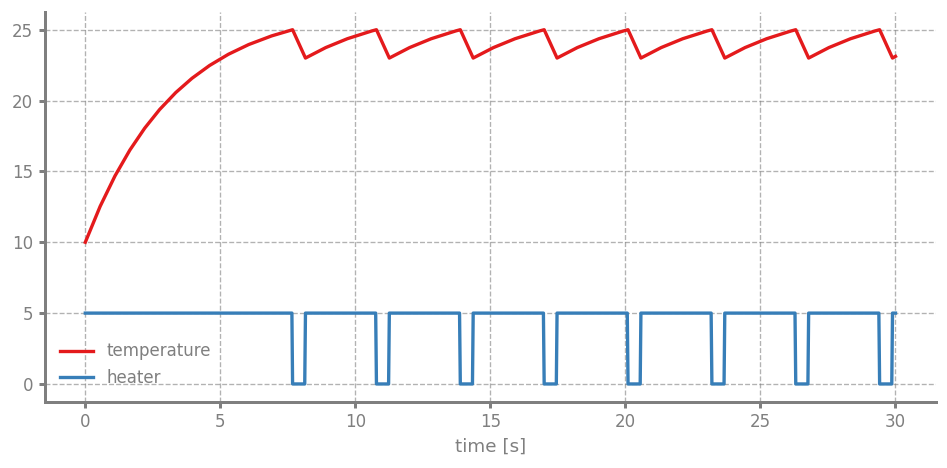

In [8]:
# Plot the results from the scope
fig, ax = sco.plot()
plt.show()

There we can clearly see the switching of the heater and the room temperature oscillating between the upper and lower threshold. We can also add the events to the plot by just iterating the events to get the detected event times

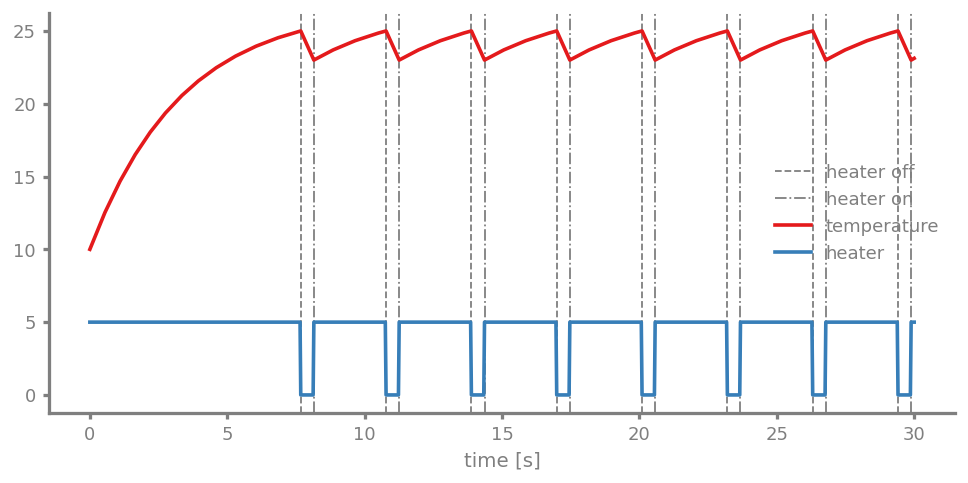

In [9]:
# Thermostat switching events - plot with event markers
time, [tp, ht] = sco.read()
fig, ax = plt.subplots(figsize=(9, 4), dpi=130)
for t in E1: 
    ax.axvline(t, ls="--", lw=1, c="gray", label="heater off" if t == list(E1)[0] else None)
for t in E2: 
    ax.axvline(t, ls="-.", lw=1, c="gray", label="heater on" if t == list(E2)[0] else None)
ax.plot(time, tp, label="temperature")
ax.plot(time, ht, label="heater")
ax.set_xlabel("time [s]")
ax.legend()
plt.show()